## Assignment 1 - Due 07 May 2018, 5:00pm

# COMP5318 - Machine Learning and Data Mining - S1 2018

Please refer to [Description File](https://drive.google.com/open?id=1fUFTqcjbSR75tiS48imwjlEVxZVS6U42YElwoVPexwY) for information about the assignment.



#### Group Members (name and student number):
##### Canves group no 17


*   Mohammad Ashraful Siddique(480163411)

*   Mohammed G Zilani (470535297)

*   Syed Mehedi Hasan(480255897)






---



## Authenticate and create PyDrive client.

You will be prompted with a link to click on, and give permission to Google Colab to access your Google Drive. If you don't want to give permission to your personal google drive, create a new gmail account, and complete this process using the new account.

In [0]:
!pip install -U -q PyDrive
!pip install -U -q google

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


## Import data
Locate the "Data" folder in your drive. Right click and click "share" to get the ID of the folder. Replace < Data folder id > with the id you got. (id should look like "1j8oG_vCmum965Ghg8LdbSkfj-lfi-AZ0" )

In [0]:
import pandas as pd
import io
import gc
import sys
import psutil
import numpy as np
import matplotlib.pyplot as plt
#import sklearn
import random
import time


#from scipy import misc
%matplotlib inline




In [3]:
#Please change the id if required

#1qNsyVt9JOj7azJcwIou74jEv-COlK9yx
file_list = drive.ListFile({'q': "'1qNsyVt9JOj7azJcwIou74jEv-COlK9yx' in parents and trashed=false"}).GetList()

for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: training_labels.csv, id: 1V3JEt1AJ1c_Ij6ZzGp54gOpOOWlsSJW8
title: training_desc.csv, id: 19mpLRJg0Eq8o5nP74MVvcIToit3MJHjq
title: training_data.csv, id: 1fHbv31j-jWX144KAaeXiQ16_94MLXMxm
title: test_data.csv, id: 1hhBp69-BBY2uL-jhKartC0QLoY4aziyV


### Pulling data into Google Colab.

In [4]:
#This was a given code. It is now moved to where data are loaded

#training_data_downloaded = drive.CreateFile({'id': '1DGZnoEwQBb9IXg8sJGDOSogmBGmGr-s3'})
#training_data_downloaded.GetContentFile('training_data.csv')


#training_desc_downloaded = drive.CreateFile({'id': '1CuYndZWzNWhORrGre_Ne5NtJvx0r47tZ'})
#training_desc_downloaded.GetContentFile('training_desc.csv')

#training_labels_downloaded = drive.CreateFile({'id': '1V3JEt1AJ1c_Ij6ZzGp54gOpOOWlsSJW8'})
#training_labels_downloaded.GetContentFile('training_labels.csv')

#test_data_downloaded = drive.CreateFile({'id': '1yhLvj6O_Y2q4MEfMCBPt3V0SzBIH8Vpv'})
#test_data_downloaded.GetContentFile('test_data.csv') 

psutil.virtual_memory()

svmem(total=13662035968, available=12649644032, percent=7.4, used=492879872, free=1761894400, active=2081255424, inactive=9103073280, buffers=137555968, cached=11269705728, shared=260018176, slab=630923264)

## Constants and generic functions

In [0]:
# Constants and parameters
TF_IDF_THRESHOLD = 0.023
MIN_NON_ZERO_VALUES = 20
PCA_COLS = 200
#TRAIN_SIZE = 0
#TEST_SIZE = 0

In [0]:
#Functions
def scale_mat(mat):
  #get the min and max of the matrix columns. Now make multiple copy (by no. of rows) of the row to make it a matrix
  min_matrix = np.array(list(np.min(mat,axis=0)) * mat.shape[0]).reshape(mat.shape) 
  max_matrix = np.array(list(np.max(mat,axis=0)) * mat.shape[0]).reshape(mat.shape) 
  return (mat-min_matrix)/(max_matrix-min_matrix)

def myPCA(A,r):
  U, s, Vt = np.linalg.svd(A, full_matrices=False)
  pc = np.matmul(U[:,:r], np.diag(s[0:r]))
  return pc

### Load data files


In [7]:
#Load training file and return matrix

def load_train():
  training_data_downloaded = drive.CreateFile({'id': '1fHbv31j-jWX144KAaeXiQ16_94MLXMxm'})
  training_data_downloaded.GetContentFile('training_data.csv')
  Y_train_apps = pd.read_csv('training_data.csv',usecols = [0],engine ='c',header=None)[0].tolist()
  df_train = pd.read_csv('training_data.csv',index_col = 0,engine ='c',header=None).as_matrix()
  #df_train.apply(pd.to_numeric,downcast='float')
  return Y_train_apps , df_train

Y_train_apps , X_train = load_train()
TRAIN_SIZE =  len(Y_train_apps)

gc.collect()
psutil.virtual_memory()

svmem(total=13662035968, available=4396642304, percent=67.8, used=8745885696, free=236871680, active=10236502016, inactive=2576941056, buffers=137007104, cached=4542271488, shared=260018176, slab=504221696)

In [8]:
def load_test():
  test_data_downloaded = drive.CreateFile({'id': '1hhBp69-BBY2uL-jhKartC0QLoY4aziyV'})
  test_data_downloaded.GetContentFile('test_data.csv') 
  Y_test_apps = pd.read_csv('test_data.csv',usecols = [0],engine ='c',header=None)[0].tolist()
  df_test = pd.read_csv('test_data.csv',index_col = 0,engine ='c',header=None).as_matrix()
  #df_train.apply(pd.to_numeric,downcast='float')
  return Y_test_apps , df_test

Y_test_apps , X_test = load_test()
TEST_SIZE =  len(Y_test_apps)

gc.collect()
psutil.virtual_memory()


svmem(total=13662035968, available=4494802944, percent=67.1, used=8647725056, free=208007168, active=10207989760, inactive=2637524992, buffers=137240576, cached=4669063168, shared=260018176, slab=503717888)

In [0]:
#To load data on local machine

#df_train = pd.read_csv('./data/training_data.csv',header=None)
#df_test = pd.read_csv('./data/test_data.csv',header=None)
#TRAIN_SIZE =  df_train.shape[0]
#TEST_SIZE  =  df_test.shape[0]
#df_train_desc = pd.read_csv('./data/training_desc.csv',header=None) # NOT USED
#df_training_labels = pd.read_csv('./data/training_labels.csv',header=None)
#df_training_labels.columns = ['app_name','label']

#Y_train_apps = df_train[df_train.columns[0]].copy()
#df_train[df_train.columns[0]]=None
#gc.collect()
#X_train = df_train[df_train.columns[1:]].as_matrix()
#del df_train

#Y_test_apps = df_test[df_test.columns[0]].copy()
#df_test[df_test.columns[0]]=None
#X_test = df_test[df_test.columns[1:]].as_matrix()
#del df_test
#gc.collect()

In [9]:
print('TRAIN_SIZE ',TRAIN_SIZE)
print('OUTPUT_SIZE ',TEST_SIZE)
X_train.shape


TRAIN_SIZE  20104
OUTPUT_SIZE  2233


(20104, 13626)

### Load and prepare (enumerate) Class labels

svmem(total=13662035968, available=4488183808, percent=67.1, used=8654303232, free=200138752, active=10209374208, inactive=2637836288, buffers=137392128, cached=4670201856, shared=260018176, slab=503701504)

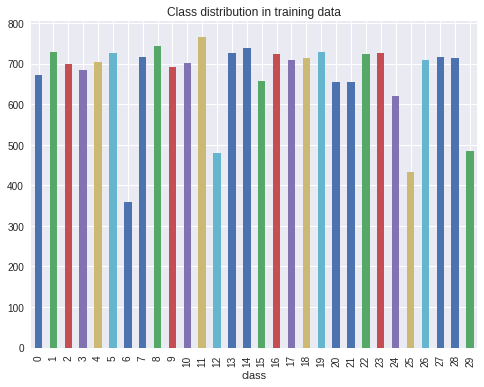

In [10]:
#Load training labels

training_labels_downloaded = drive.CreateFile({'id': '1V3JEt1AJ1c_Ij6ZzGp54gOpOOWlsSJW8'})
training_labels_downloaded.GetContentFile('training_labels.csv')

df_training_labels = pd.read_csv('training_labels.csv',header=None)
#df_train.columns
df_training_labels.columns = ['app_name','label']

# Enumerate the classes
labels = sorted(df_training_labels['label'].unique())
labels = pd.DataFrame(list(enumerate(labels)))
labels.columns=['class','label']


# get the class labels of training data
app_names = pd.DataFrame(Y_train_apps)
app_names.columns = ['app_name']
app_labels = pd.merge(app_names,df_training_labels,how='left',on=['app_name'])
app_class = pd.merge(app_labels,labels,how='left',on = ['label'])


Y_train = app_class['class'].as_matrix()
train_label_count = np.bincount(Y_train)

# Distribution of labels in the training data

def bar_count():
  #print(train_label_count)
  df_ = pd.DataFrame( {'class':range(len(train_label_count)),'count':train_label_count })
  df_.plot.bar(x='class',y='count',figsize=(8,6),legend=False,title = 'Class distribution in training data')
bar_count()

del app_names
del app_labels
del app_class

gc.collect()
psutil.virtual_memory()

## Prepare Data 


### Check training data statistics

min: 0.0015215438539236301
max: 9.95628902658394
mean: 0.07413565037450766
median: 0.0417538963701832
std: 0.1167056442797558
25 percentile: 0.0236182690184739
50 percentile: 0.0417538963701832
75 percentile: 0.0796778312680785
skew  9.558383705470167
kurtosis  230.6501099072033


Text(0.5,1,'tf-idf(<.2) histogram ')

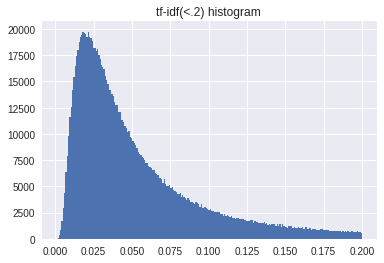

In [11]:
from scipy.stats import skew
from scipy.stats import kurtosis

print('min:',np.min(X_train[X_train>0]))
print('max:',np.max(X_train[X_train>0]))
print('mean:',np.mean(X_train[X_train>0]))
print('median:',np.median(X_train[X_train>0]))
print('std:',np.std(X_train[X_train>0]))
print('25 percentile:',np.percentile(X_train[X_train>0],25))
print('50 percentile:',np.percentile(X_train[X_train>0],50))
print('75 percentile:',np.percentile(X_train[X_train>0],75))
print('skew ',skew(X_train[X_train>0]))
print('kurtosis ',kurtosis(X_train[X_train>0]))

ax = plt.hist(X_train[((X_train>0) & (X_train <.2))],bins='auto')
plt.title('tf-idf(<.2) histogram ')

In [0]:
# Eliminate insignificant value

# Consider tf-idf < TF_IDF_THRESHOLD as stop words

X_train[X_train< TF_IDF_THRESHOLD] = 0
X_test[X_test< TF_IDF_THRESHOLD] = 0

### Check columns that has very little or no data

Training data shape: (20104, 5002)
Test data shape: (2233, 5002)


svmem(total=13662035968, available=4489318400, percent=67.1, used=8653205504, free=199585792, active=10211139584, inactive=2638655488, buffers=137883648, cached=4671361024, shared=260018176, slab=503689216)

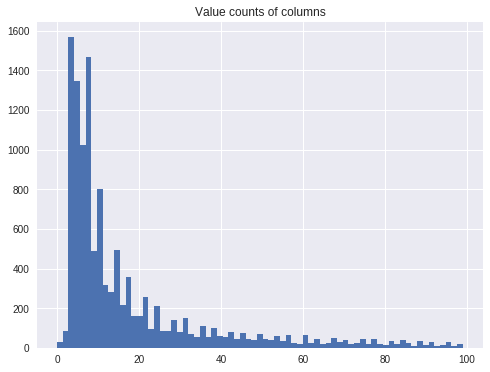

In [13]:
#remove some insignificant columns

#MIN_NON_ZERO_VALUES = 20 #initialised at the top

col_sums = np.sum(X_train>0,axis=0)
plt.figure(figsize=(8,6))
ax = plt.hist(col_sums[col_sums<100],bins='auto')
plt.title('Value counts of columns')

X_train = X_train[:,col_sums >= MIN_NON_ZERO_VALUES ]

X_test = X_test[:,col_sums >= MIN_NON_ZERO_VALUES ]

print('Training data shape:',X_train.shape)
print('Test data shape:',X_test.shape)

gc.collect()
psutil.virtual_memory()

### Concatenate training and test matrix

In [14]:

#Stack the matrix one top of another
A = np.row_stack((X_train,X_test)) 

#This is the master matrix 

#First TRAIN_SIZE rows are training data and last TEST_SIZE are test data. 

#The two dataset need to be merged together before extracting principal components and scaling. If scaling is done separately, there is a chance that 
# the denomination would be different. 


print('Total dataset size:',A.shape)

#To save some memory remove the original matrix. 
del X_test
del X_train
gc.collect()
psutil.virtual_memory()

Total dataset size: (22337, 5002)


svmem(total=13662035968, available=4486172672, percent=67.2, used=8656351232, free=196227072, active=10211495936, inactive=2638745600, buffers=137973760, cached=4671483904, shared=260018176, slab=503685120)

##  PCA (by SVD) on the total dataset and scale

[0.24191613 0.34211658 0.41539875 0.47461431 0.52469444 0.56802528
 0.60612885 0.64000564 0.67045375 0.69797613 0.72295304 0.74572793
 0.76657285 0.78569589 0.80329012 0.81950254]


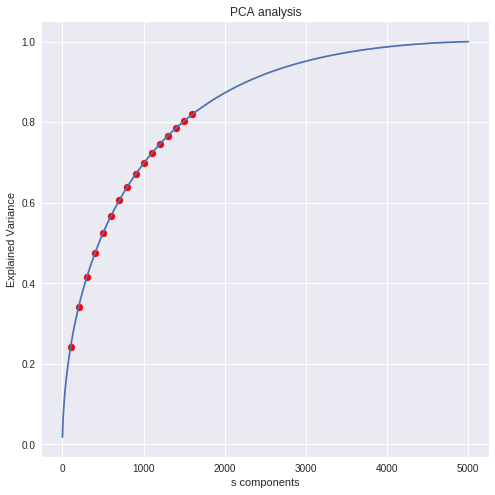

In [15]:
# This section is used only for visualising the 
# Run SVD and plot eigen values

def PCA_Analysis(A):
  U, s, Vt = np.linalg.svd(A, full_matrices=False)
  plt.figure(figsize=(8,8))
  var_explained = (np.cumsum(s**2)/np.sum(s**2))
  plt.plot(var_explained)
  x_ = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600]
  y_ = var_explained[x_]
  plt.scatter(x= x_,y=y_,color='red')
  plt.ylabel('Explained Variance')
  plt.xlabel('s components')
  plt.title('PCA analysis')
  print(y_)

PCA_Analysis(A)

In [16]:
#Take 'PCA_COLS:200' Prnciple Components
#Scale the total

t1 = time.time() #for timing
A = myPCA(A,PCA_COLS)
A = scale_mat(A)
print(time.time() -t1)
gc.collect()
psutil.virtual_memory()

269.3557255268097


svmem(total=13662035968, available=4259520512, percent=68.8, used=8882991104, free=179036160, active=10363805696, inactive=2523070464, buffers=139632640, cached=4460376064, shared=260018176, slab=495771648)

In [17]:
# Recreate training and test dataset 

X_train = A[:TRAIN_SIZE,:]
X_test = A[TRAIN_SIZE:,:]
#del pca_scaled
gc.collect()
psutil.virtual_memory()

svmem(total=13662035968, available=4259422208, percent=68.8, used=8883085312, free=178417664, active=10364489728, inactive=2523406336, buffers=139763712, cached=4460769280, shared=260018176, slab=495742976)

In [18]:
# check the data size once again
print(X_train.shape)
print(X_test.shape)

(20104, 200)
(2233, 200)


# K-NN Implementation

### Create training and validation sets

In [25]:
# create training and validation set to measure accuracy of the model


t1 = time.time()  
idx = np.arange(0,X_train.shape[0]) # create an array of sequence of size = train data size
#np.random.seed(201452)
trn_idx = np.random.choice(idx,size=int(X_train.shape[0]*.85),replace=False) #create random indexes of for training set
tst_idx = np.setdiff1d(idx,trn_idx) #create validation set with rest of the data

#print(time.time() -t1   ) 
Xtrn = X_train[trn_idx,:] #training set
Xtst = X_train[tst_idx,:] #validation set
Ytrn = Y_train[trn_idx]   #train lables
Ytst = Y_train[tst_idx]   #validation labels
#print(Ytrn[0:10])
#print(Ytst[0:10])
print(time.time() -t1   ) 
gc.collect()
psutil.virtual_memory()

0.018025875091552734


svmem(total=13662035968, available=4260421632, percent=68.8, used=8882106368, free=174567424, active=10370437120, inactive=2525827072, buffers=141795328, cached=4463566848, shared=260018176, slab=495710208)

### Distance and class prediction function

In [0]:
from scipy.spatial import distance_matrix

import time


def KNN(X,Y,X_,Y_,K=5):
    #K=7 #Neighbours
    #X=Xtrn #training set for the algorithm
    #X_ = Xtst #test set for the algorithm
    #Y = Ytrn #label of the training set
    #Yact=Ytst #actual label of the test set
    
    #calculate the distance matrix
    t1 = time.time()   
    dist_mat = distance_matrix(X,X_) 
    #print('Distance matrix finished.',time.time() -t1,'sec'   ) 

    #argsort to find the closest neighbours and sort to find the distances
    arg_sort_mat = np.argsort(dist_mat,axis=0)[:K] 
    sorted_mat = np.sort(dist_mat,axis=0) [:K]
    #print(time.time() -t1   ) 

    #Find K neighbours lebel and distance
    label_mat= Y[arg_sort_mat.flatten()].reshape(arg_sort_mat.shape)
    #print(time.time() -t1   ) 

    #Weight Matrix
    sorted_mat[sorted_mat==0] = 0.0000000001 #to avoid divide by 0 error
    weight_mat = np.reciprocal(sorted_mat)**2 #weight is inverse of square of the distance

    #print(time.time() -t1   ) 
    
    # Determine the class
    lbls = np.array(labels['class'])
    weight_sum = np.array([])
    for i in lbls:
        #print(i)
        x = weight_mat.copy()
        x[label_mat!=i]=0
        weight_sum = np.append(weight_sum,x.sum(axis=0))

    weight_sum = weight_sum.reshape(lbls.shape[0],weight_mat.shape[1])
    
    Y_pred = np.argsort(weight_sum,axis=0)[-1,:]  
    
    
    ac=-1
    try:
      ac = (sum(Y_==Y_pred)/Y_.shape[0])
    except: 
      pass
    #print('Total:',time.time() -t1,'sec'   )
    print(K,ac)
    
    return  Y_pred,ac

#KNN(Xtrn,Ytrn,Xtst,Ytst,21)

In [26]:
# Check total Accuracy and get prediction usign test and validation set

Y_pred,x = KNN(Xtrn,Ytrn,Xtst,Ytst,K=9)
print('Accuracy:',np.round(np.sum(Ytst==Y_pred)/Ytst.shape[0]*100,2),'%')
gc.collect()
psutil.virtual_memory()

9 0.5656498673740054
Accuracy: 56.56 %


svmem(total=13662035968, available=4266258432, percent=68.8, used=8876269568, free=179531776, active=10365562880, inactive=2526404608, buffers=142008320, cached=4464226304, shared=260018176, slab=495661056)

In [27]:
# Draw the confusion matrix. 

actvspred=pd.DataFrame({'act':Ytst,'pred':Y_pred})
df1= pd.crosstab(actvspred['act'],actvspred['pred'])
#print(df1)
print(df1[df1.columns[:15]])
print(' ')
print(df1[df1.columns[15:]])

pred  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
act                                                             
0     56   0   3   0   2  10   0   0   0   1   0   0   0   0   0
1      1  56   0   3   0   3   3   0   9   1   0   4   1   4   0
2     12   1  53   0   3   3   0   1   8   4   0   0   0   0   0
3      0   2   1  37   1   1   0   5   2   0   6   0   1   1   4
4      2   2   6   0  90   1   0   0   0   0   0   1   0   1   1
5     19   4   7   0   4  32   0   1   5   4   0   1   0   2   0
6      1   1   1   0   0   1  29   0   3   3   0   0   0   0   1
7      1   1   1   7   0   0   1  64   0   1   1   0   0   1   1
8      2   8   4   2   0   4   0   3  61   0   1   1   2   1   2
9      7   1   1   2   0   8   2   3   4  23   1   0   2   1   3
10     0   1   1   6   0   0   0   2   0   0  89   2   0   0   0
11     2   2   1   1   1   0   1   0   4   1   1  67   0   3   0
12     0   3   1   2   0   2   0   2   1   1   1   0  32   0   3
13     3  16   0   4   3 

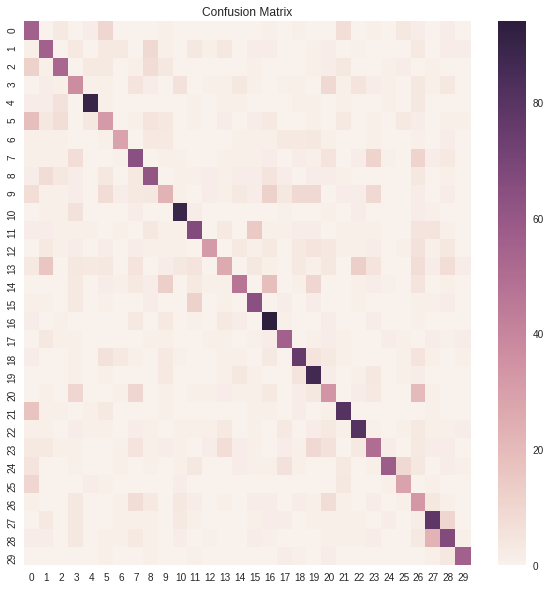

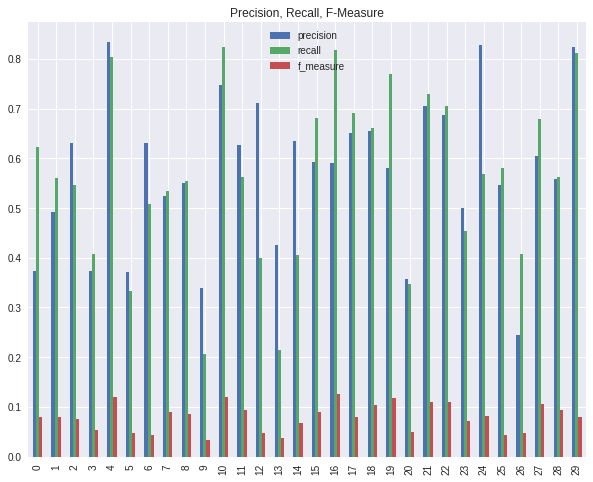

In [28]:
# Precision, Recall and F-measure for each class

import seaborn as sns
counts = len(Ytst)
Ytst_bincount=np.bincount(Ytst)
Y_pred_bincount=np.bincount(Y_pred)
Ytst_bincount
plt.figure(figsize=(10,10))
confusion_mat = df1.as_matrix()
sns.heatmap(confusion_mat).set_title('Confusion Matrix')
correct_count =  np.diagonal(confusion_mat) #The diagonal values are correctly predicted

recall = correct_count/Ytst_bincount # Recall = correctly predicted value compared to actual. How many are correctly predicted for each class.
precision = correct_count/Y_pred_bincount # Precision = correctly predicted value compared to predicted values. How many of the predicted are correct for each class.
b_c = counts - sum(correct_count)
f_measure = (correct_count*2)/((correct_count*2)+b_c)
df_res = pd.DataFrame({'act': Ytst_bincount,'pred':Y_pred_bincount,'correct':correct_count,'precision':precision,'recall':recall,'f_measure':f_measure})
df_res[['precision','recall','f_measure']].plot.bar(title='Precision, Recall, F-Measure',figsize =(10,8))

#print(df_res[['act','pred','correct','precision','recall','f_measure']])
#print(Ytst_bincount)
#print(Y_pred_bincount)
#print(correct_count)
#print(np.round(recall,2))
#print(np.round(precision,2))
#print(np.round(f_measure,2))

## Predict the output of the test data

In [29]:
#Predict output and prepare output format in a dataframe

Y_pred,x = KNN(X_train,Y_train,X_test,None,31)

Y_pred_labels = list((labels['label'])[Y_pred.flatten().tolist()])
df_pred = pd.DataFrame({'app':Y_test_apps,'class':Y_pred_labels})

31 -1


In [30]:
#Write output to a google drive file

target_output_google_folder = '1axO01qqZdqtjrXzgL4zkX6a7Aa0H9Anx'  #please change this to save the output in a different folder. Please make sure running user has access to the folder.

output_file = drive.CreateFile({'title': 'predicted_labels.csv',"parents": [{"kind": "drive#fileLink","id":target_output_google_folder }]})
output_file.SetContentString(df_pred.to_csv(header=None,index=None))
output_file.Upload()
print('Successfully writen to ID {}'.format(output_file.get('id')))

Successfully writen to ID 1uy9wZFuhHZaPFIL5HoykGFXeUMhzcERE


### Optimise the value of K

1 0.5208885941644562
5 0.5580238726790451
9 0.5656498673740054
13 0.5676392572944297
17 0.5646551724137931
21 0.5643236074270557
25 0.5610079575596817
29 0.5593501326259946
33 0.5586870026525199
37 0.5580238726790451
41 0.5576923076923077
45 0.5563660477453581
49 0.5550397877984085


Text(0,0.5,'Accuracy')

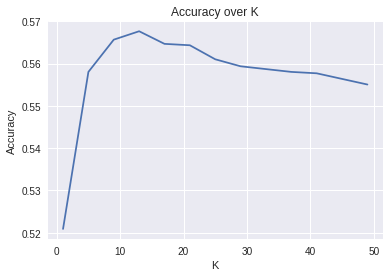

In [31]:
# get accuricy for a list of K

Acc =  [KNN(Xtrn,Ytrn,Xtst,Ytst,k)[1] for k in range(1,53,4)]

#PCA 200
ax = plt.plot(range(1,53,4),Acc)
plt.title('Accuracy over K')
plt.xlabel('K')
plt.ylabel('Accuracy')

#Which one has the best accuracy?



---


#COMP5318-MACHINE LEARNING AND DATA MINING
##Assignment 1



## A. Introduction:

Mobile app user is increasing day by day all over the world in almost all ages. Whenever we need to use the app, we easily go to app store platforms in order to find the related app to full fill our purposes. People can get their suitable app in any ages or in any topics.  Almost over a million of app is exists in the app store and google play.  We can see thousands of apps like gaming, educational, lifestyle, travel, entertainment, business, utility, health and beauty and so on. We can see the apps in all most every topics and there are huge numbers of them.  Since this number is huge, app users are also becoming confused to see the verities and also confused to know which app they will use.  it is growing demand to know the class of the apps based on their function and utility. Scientists and researcher are continuously trying to build perfect classifier to classify the apps in the market. 


In this project the initiative has been taken to implement a machine learning algorithm, to classify the apps based on the description of the apps and some other data files.  It has been examined four given CSV files where we tried to figure out the data pattern and tried to find out the best solution for classify the apps.  From the training data.csv file where the apps description and some Colum of TF-IDF (Term Frequency- Invert Document Frequency), been tried to build the best classifier.  









This was challenging to select the perfect algorithm in order to classify the applications. Since most of the classification machine learning algorithm is time consuming, we have been tried to use the KNN as a supervised learning technique. Our aim was to apply the KNN algorithm to build up our model where we used the training levels.csv file to see the name of the apps and all together 30 categories. The effectiveness of this algorithm was examined by using confusion matrix, f1 and some other statistical variances.  

Since there are a huge number of app is in the market, it is important for the user to discover the way to understand what kind of app are we using. Scholar and the researchers in the machine learner field have a huge option to think about the app classifier and make a perfect solution for the users. Within such a huge number of apps in the market the classification is important to differ the apps from one another. Machine learning process has been widely used to classify this kind of vast amount data and make a classifier within them. Machine learning algorithm is best way to make the model to classify the apps already in the market and also will be able to classify the future apps.  




* the following link showing the Machine learning process:

    * https://drive.google.com/open?id=1_KTmqO9WSJw01ISSvfKwfnBsRSqDDujo
    <img src="https://drive.google.com/uc?export=view&id=1_KTmqO9WSJw01ISSvfKwfnBsRSqDDujo">

## B. Methods 

### Pre-processing 

###Data set description: 
###The dataset is collected from the Apps Market. There are four main ﬁles:

####1. training_data.csv:
* There are 20,104 rows; each row corresponds to an app. 

* For each row, each column is separated by comma (,). The ﬁrst column is the app’s name, with the remaining columns containing the tf-idf values. The tf-idf values are extracted from words in the description of each app. We have done some pre-processing steps which resulted in 13,626 unique words. If a word is found in the description of an app, it has a tf-idf value (the tf-idf value is not zero). On the other hand, its tf-idf value is equal to zero if the word is not found in the description of the app. More information about tf-idf could be found in http://en.wikipedia.org/wiki/Tf%E2%80%93idf

* In summary, data train.txt is a matrix with dimension: 20,104×13,627 (remember the ﬁrst column is the app’s name).

####2. training_desc.csv: 
* There are 20,104 rows; each row is for an app. 

* For each row, each column is separated by comma (,). The ﬁrst column is the app’s name and the second column contains the app’s description.

####3. training_labels.csv: 
* There are 20,104 rows; each row is for an app. 
* For each row, each column is separated by comma (,). The ﬁrst column is the app’s name and the second column is for the label.
* There are 30 unique labels in total, for example Casual, Health and Fitness, etc.

Note that it is not necessary that the same rows of two training ﬁles refer to the same app. Please use the app’s name as a reference. 

####4. test_data.csv: 
* This is a subset of the original data set; we have split the original data set into 90% for training set and 10% for test set (per label). This ﬁle should NOT be used for training the classiﬁer. 
	
* Your code must be able to read the test set, and output a ﬁle “predicted_labels.csv” in the same data-format as “training_labels.csv”. Make sure the predictions (classiﬁcation results for the test set) are in the same order as test inputs, i.e. the ﬁrst row of “predicted_labels.csv” corresponds to the ﬁrst row of “test_data.csv” and so on). 

* The score will be based on how accurate your approach is. We will collect “predicted_labels.csv” and compare it to the actual labels to get the accuracy of your approach. For further testing purposes, we may use a diﬀerent test set while grading.

###Load Data:
Training data training_data.csv was loaded from Google Drive into a Google Colaboratory (Google, 2018) python notebook using Pandas Data frame. The first column (application name) had been treated as index and auto column naming has been used which enumerates the columns from 0 to column numbers. Similarly test_data.csv and training_labels.csv had also been loaded into the notebook. 



###Convert to NumPy matrix (while loading data): 
It had been observed that pandas data frames was consuming almost all the memory available in Colab virtual environment (12GB).  Moreover, after any data manipulation the memory was not released properly which was causing the notebook to restart. To resolve the issue, the application names had been taken into string lists and the rest of the data had been converted to NumPy 2D array for both training and test data. Moreover, the loading was executed in a function so that all overhead objects (data frame, file streams etc.) are created as local variable and help the system release memory once the codes had been executed, keeping only useful data in the memory. 



###Load and prepare class labels:
Both application name and labels were loaded from training_labels.csv file then mapped to original sequence of the training data using Pandas dataframe. At his point sorted list of the labels were created and enumerated for the ease of future operation. In the next step enumerated values (0 to 29) were added to corresponding value of the training application list. Finally training data labels (Y_train) has been created as an integer array.  Visualisation has been generated to understand class distribution. It has been observed data were mostly distributed among classes evenly. Only 4 classes has significantly less number of data than the average.
* The following link is showing class distribution on training data
    *  https://drive.google.com/open?id=1irWbqfL8CrXxkEZ_9oJ_p7DGXyswYdTW
 <img src="https://drive.google.com/uc?export=view&id=1irWbqfL8CrXxkEZ_9oJ_p7DGXyswYdTW">


###TF-IDF value statistics and eliminate less significant values:
The tf-idf value represents the importance of the words, therefore lower tf-idf values are less relevent and higher values are more relevant (community, 2017). A summary statistics has been taken for all non-zero tf-idf values to understand the values and determine the percentiles. From the histogram it has been observed that most of the values are miniscule. The non-zero min value is 0.00152 and max value is 9.95; however, the 25th percentile is only 0.023. Therefore it had been decided to remove the values less than 0.023 as stop words. Nevertheless, the threshold value for tf-idf was optimised based on the accuracy  of the experiment result. 
    
    Tf-idf statistics of the non-zero training dataset
    min: 0.0015215438539236301
    max: 9.95628902658394
    mean: 0.07413565037450766
    median: 0.0417538963701832
    std: 0.1167056442797558
    25 percentile: 0.0236182690184739
    50 percentile: 0.0417538963701832
    75 percentile: 0.0796778312680785
    skew  9.558383705470167
    kurtosis  230.6501099072033

* The following link is showing tf-idf histogram
    *  https://drive.google.com/open?id=1OewX9utlcrw7nPgA_HBE-ZhL8AF2NZyr

<img src="https://drive.google.com/uc?export=view&id=1OewX9utlcrw7nPgA_HBE-ZhL8AF2NZyr">



###Eliminate less significant columns: 
It has been assumed that member of a class would share the same set of words; i.e. some of the members of the same class would have similar value in identical columns. Therefore, those words that appear very rarely (<20) may be relevant for a member but not necessarily significant for the entire class. Moreover, highly sparse columns would create extra distance between members of the same class.  Therefore, highly sparse columns were removed from the training set, and the same columns were removed from the given test set. This had reduced number of columns from 13626 to 7624.

  * The following link is showing the resultant curve of eleminating of less significant colum.
      *  https://drive.google.com/open?id=1k1F5oKnMXBVWEmOwPbc-9KZLFgZmSy2b
      <img src="https://drive.google.com/uc?export=view&id=1k1F5oKnMXBVWEmOwPbc-9KZLFgZmSy2b">



###Dimensionality Reduction (Singular Value Decomposition and Principal Component Analysis):
The dimension of the given dataset is considerably high which would prevent the machine learning algorithms to converge. Therefore, it had been decided to execute principal component analysis using singular value decomposition. The svd() function from linalg module of  python package Numpy was used for the SVD decomposition. Principal components and explained variances were computed from the decomposed values. From the following graph first 600 components explains almost 55% of the information. Therefore it was decided to use 600 principal components which reduced most of the noises. 

Detailed discussion of the PCA analysis using SVD is beyond the scope of this analysis. However, it can be explained in short as 
Singular value decomposition takes a rectangular matrix of gene expression data (defined as A, where A is a n x p matrix) in which the n rows represents the genes, and the p columns represents the experimental conditions. The SVD theorem states:
 
Anxp= Unxn Snxp VTpxp
 
Where
UTU = Inxn
VTV = Ipxp  (i.e. U and V are orthogonal)
				(Singular Value Decomposition (SVD) tutorial, 2018)

####Code
    # This section is used only for visualising the 
    # Run SVD and plot eigen values

    def PCA_Analysis(A):
      U, s, Vt = np.linalg.svd(A, full_matrices=False)
      plt.figure(figsize=(8,8))
      var_explained = (np.cumsum(s**2)/np.sum(s**2))
      plt.plot(var_explained)
      x_ = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600]
      y_ = var_explained[x_]
      plt.scatter(x= x_,y=y_,color='red')
      plt.ylabel('Explained Variance')
      plt.xlabel('s components')
      plt.title('PCA analysis')
      print(y_)

    PCA_Analysis(A)

  * The following link is showing the PCA explain variation curve
      *  https://drive.google.com/open?id=1PTiMYpBT4cBfzMfAztXH21CwG34OumaX
<img src="https://drive.google.com/uc?export=view&id=1PTiMYpBT4cBfzMfAztXH21CwG34OumaX">


###Scaling:
K-NN (K Nearest Neighbourhood) algorithm measures the distance between labelled data points to the new data point to determine the nearest neighbours using various distance function. Euclidian distance function, which was used in this assignment, is influenced by the range of the continuous attributes. Attributes that had larger range would have more contribution to the distance, whereas attributes with shorter range would have less portion of the calculated distance. Therefore the distance would be biased to larger attributes. To resolve this issue all attributes are scaled to a continuous value between 0 to 1 using following equation.

    new value = {Old value – min(old value) } / {max(old value) – min(old value)}



###Concatenate training and test data before PCA and Scaling:
The training and test data matrixes was concatenated together vertically to form one matrix before dimensionality reduction (PCA) and scaling. This was a necessary step to ensure that, a) PCA was done uniformly on same linear space and scaling was done using same denomination for both training and test data. After PCA and scaling data was split again based on row index and X_train and X_test was obtained which was then fed into K-NN classifier.




## Classifier

###Motivation to choose the Algorithm:
It was decided to use KNN (K Nearest Neighbourhood) as the classification algorithm for its effectiveness. 
KNN does not create a model upfront, rather it measures the distance and checks the nearest neighbours to classify a new data point; therefore it is a lazy learner. In a real scenario, large number of applications are added to the Google application marketplace every day which are evolving dynamically. So, using a classifier which can adopt the changes readily would be advisable. In case of KNN, to add new class to the model is as easy as adding new set of data to the training data set. Thus it is a logical choice for primary algorithm to classify application based on the description words. Nevertheless, proper and relevant description is required regardless of any choice of algorithm.




###Algorithm Description:
KNN (k nearest neighbourhood) algorithm is a simple way to classify an unknown data point based on the distance (or similarity) measure between the unknown data point to the labelled data points. KNN has been used machine learning and pattern recognition since from early 1970. 

###Measurement of Distance to new record:
In order to compute the nearest neighbour the following are required:
* Labelled training data set which would be used to measure the distance.
* Compute the distance matrix between new data to all labelled data.
* And the value of K (the number of neighbour that would influence the new class label, whichever is nearest or strongest) (Bishop, 2018)





*  the following link is measurement of new data in KNN
  *    https://drive.google.com/open?id=1HLTYtbR99m4H98OxiIvlnqf4gxvJnXJh

<img src="https://drive.google.com/uc?export=view&id=1HLTYtbR99m4H98OxiIvlnqf4gxvJnXJh">

###New data classification:
In order to classify the new record, it required to 
* Measure the distance between the new data to the training records; in this case we used Euclidean distance function where x and y are two data point of n attributes (or dimension).  
 
* The next step is to Identify K nearest neighbour.
* Take the majority voting of class level among the K-nearest neighbours associated with the new data point and then weight the vote according to the distance weight factor. 


###Majority voting system:
Computation of KNN is depends on the majority voting system which mean if we want to see which class is the X belongs to, in a k=6 system as shown in the figure, it is require to  see which class has strongest influence. Here in the figure x belongs to class-2; given that, from class 2 X has maximum 3 neighbours, from class 1 one neighbour and from class 3 there two neighbours.
	 



* the following link showing the pic of majority voting system
  *  https://drive.google.com/file/d/1HLTYtbR99m4H98OxiIvlnqf4gxvJnXJh

##KNN implementation:
#####Create training and validation set:
The training data set was divided into training and validation data, where 85% was taken as training data and 15% was validation data.    
Code:

#####Calculating Distance and predicting class:
Class of the new point was detected using following steps:
1.	The distance matrix was calculated using Euclidian distance. For m training data and n validation data an m x n distance matrix was generated. Calculating the distance matrix is the most costly step of the algorithm. 
2.	Once the distance matrix was calculated using Numpy.argsort() function the closest K neighbours was detected and the inverse of the distance was calculated to use as voting weight.  
3.	Weighted votes were summed for each class label
4.	Class label with highest weighted vote was considered as the predicted class  


### Divide the training data into 
    # create training and validation set to measure accuracy of the model
    t1 = time.time()  
    idx = np.arange(0,X_train.shape[0]) # create an array of sequence of size = train data size
    trn_idx = np.random.choice(idx,size=int(X_train.shape[0]*.85),replace=False) #create random indexes of for training set
    tst_idx = np.setdiff1d(idx,trn_idx) #create validation set with rest of the data
    #print(time.time() -t1   ) 
    Xtrn = X_train[trn_idx,:] #training set
    Xtst = X_train[tst_idx,:] #validation set
    Ytrn = Y_train[trn_idx]   #train lables
    Ytst = Y_train[tst_idx]   #validation labels
    #print(Ytrn[0:10])
    #print(Ytst[0:10])
    print(time.time() -t1   ) 
    gc.collect()
    psutil.virtual_memory()

### Distance and class prediction function

    def KNN(X,Y,X_,Y_,K=5):
    
    #K=7 #Neighbours
    #X=Xtrn #training set for the algorithm
    #X_ = Xtst #test set for the algorithm
    #Y = Ytrn #label of the training set
    #Yact=Ytst #actual label of the test set
    
    #calculate the distance matrix
    t1 = time.time()   
    dist_mat = distance_matrix(X,X_) 
    #print('Distance matrix finished.',time.time() -t1,'sec'   ) 

    #argsort to find the closest neighbours and sort to find the distances
    arg_sort_mat = np.argsort(dist_mat,axis=0)[:K] 
    sorted_mat = np.sort(dist_mat,axis=0) [:K]

    #Find K neighbours lebel and distance
    label_mat= Y[arg_sort_mat.flatten()].reshape(arg_sort_mat.shape)

    #Weight Matrix
    sorted_mat[sorted_mat==0] = 0.0000000001 #to avoid divide by 0 error
    weight_mat = np.reciprocal(sorted_mat)**2 
   
    # Determine the class
    lbls = np.array(labels['class'])
    weight_sum = np.array([])
    for i in lbls:
        #print(i)
        x = weight_mat.copy()
        x[label_mat!=i]=0
        weight_sum = np.append(weight_sum,x.sum(axis=0))

    weight_sum = weight_sum.reshape(lbls.shape[0],weight_mat.shape[1])
    Y_pred = np.argsort(weight_sum,axis=0)[-1,:]  
    ac=-1
    try:
      ac = (sum(Y_==Y_pred)/Y_.shape[0])
    except: 
      pass
    #print('Total:',time.time() -t1,'sec'   )
    print(K,ac)
    
    return  Y_pred,ac


## C. Experiments and Results 

###Determining accuracy:
The training set was divided into training and validation set (85% to 15%) in a random fashion to determine the accuracy of the algorithm using K=9 (nearest 9 neighbours).  
####Code: 
    Y_pred,x = KNN(Xtrn,Ytrn,Xtst,Ytst,K=9)

Here Y_pred and x is the accuracy which was calculated using following code
Code: 
    np.round(np.sum(Ytst==Y_pred)/Ytst.shape[0]*100,2)

####The accuracy of the algorithm using random validation set was 55.24 %.

####Confusion matrix: 
A confusion matrix was generated by using pandas dataframe crosstab function. It was observed that the diagonal of the matrix had most of the values which was expected. However, the table also revels the misclassifications tendencies. 
  
####Code: 
    actvspred=pd.DataFrame({'act':Ytst,'pred':Y_pred})
    df1= pd.crosstab(actvspred['act'],actvspred['pred'])
* this link is the picture of confusion matrix
  *  https://drive.google.com/open?id=1tpuw85mhE-8Z2vrVODB-jK0jhYz4rwce


<img src="https://drive.google.com/uc?export=view&id=1tpuw85mhE-8Z2vrVODB-jK0jhYz4rwce">

#####A heat map was also produced to analyse the data visually using Seaborn package of python. 
    confusion_mat = df1.as_matrix()
    sns.heatmap(confusion_mat).set_title('Confusion Matrix')

*  this link is the visual representation of the matrix
    *  https://drive.google.com/open?id=1m9eBbgwJFnl_laloUCTq60VEHPK-pX9T
<br>
<img src="https://drive.google.com/uc?export=view&id=1m9eBbgwJFnl_laloUCTq60VEHPK-pX9T">

##Calculating Metrics (precision, recall and f-measure): 
Precision, recall and f-measure are widely used measure for determining performance of machine learning algorithms. Precision is the ratio of number of accurate prediction to total number predicted for the class. Recall is the ratio of number of accurate prediction to actual number of class members. The f-measure is the bias towards all except other classes. Following  link shows how to calculate the above three measures. 

* link of formula
     *  https://drive.google.com/open?id=1bT_eLZqhZ5xFyI1R0JH5G_WBTHmtatCf
<img src="https://drive.google.com/uc?export=view&id=1bT_eLZqhZ5xFyI1R0JH5G_WBTHmtatCf">

 


#### Following bar graph shows the precision, recall and F-measures for the implemented KNN algorithm.

* https://drive.google.com/open?id=1-Xc_K9QRM9VvXmeWSC-16PiPDzMSzloM
<img src="https://drive.google.com/uc?export=view&id=1-Xc_K9QRM9VvXmeWSC-16PiPDzMSzloM">

####Code: 
    recall = correct_count/Ytst_bincount 
    precision = correct_count/Y_pred_bincount 
    b_c = counts - sum(correct_count)
    f_measure = (correct_count*2)/((correct_count*2)+b_c)

###Determine value of K:
The accuracy of the algorithm was heavily dependent on the value of k. Therefore different value of K was tried and accuracy was measured for each of the values. The following figure displays how value of K effected the accuracy. In the experiment the highest value of accuracy was observed for K = 9.  

####Code:
    Acc =  [KNN(Xtrn,Ytrn,Xtst,Ytst,k)[1] for k in range(1,53,4)]
    #PCA 200
    ax = plt.plot(range(1,53,4),Acc)
    plt.title('Accuracy over K')
    plt.xlabel('K')
    plt.ylabel('Accuracy')

* the following link is showing the pic of accuricy over K
  *  https://drive.google.com/open?id=1Fv32aP448t9Enc9UPEASmBpBvGPF_nhr

  <img src="https://drive.google.com/uc?export=view&id=1Fv32aP448t9Enc9UPEASmBpBvGPF_nhr">

## D. Export Results 

### Predict the values for the test data
The test_data.csv was used in the KNN() function to generate class numbers and then converted to class labels using following codes. The order of the application name was preserved and was never changed; only a second column was added. 

    #Predict output and prepare output format in a dataframe

    Y_pred,x = KNN(X_train,Y_train,X_test,None,31)

    Y_pred_labels = list((labels['label'])[Y_pred.flatten().tolist()])
    df_pred = pd.DataFrame({'app':Y_test_apps,'class':Y_pred_labels})


### Save the output to Google shared folder
Using the following code the output file  <a  href="https://drive.google.com/open?id=1hUHgE167SOH-g1ZHVQHu-3RwpczKZweR"> “**predicted_labels.csv**”</a> was saved in the shared folder created to be submitted. 

    #Write output to a google drive file

    target_output_google_folder = '1axO01qqZdqtjrXzgL4zkX6a7Aa0H9Anx'  
    #please change this to save the output in a different folder. 
    #Please make sure running user has access to the folder.

    output_file = drive.CreateFile({'title': 'predicted_labels.csv',"parents": [{"kind": "drive#fileLink","id":target_output_google_folder }]})
    output_file.SetContentString(df_pred.to_csv(header=None,index=None))
    output_file.Upload()
    print('Successfully writen to ID {}'.format(output_file.get('id')))


## E. Discussion

####Optimisation of the assumed values: 
In the experiment only the value of K was optimised, whereas the other assumptions ie. tf-idf threshold (TF_IDF_THRESHOLD), number of minimum value per column (MIN_NON_ZERO_VALUES) and number of principal components (PCA_COLS) etc. were not optimised. It has been recommended to optimise these values to obtain better result. 

####CPU time overhead: 
In case of KNN the algorithm measures distance of an unlabelled data from all labelled data points. This is a very costly operation and takes very long time. This step can be minimised by reducing training data. 



## F. Conclusion and future work

####Conclusion and Future work: 
Some times in some cases getting the information from the description of the app is difficult, because of the poor presentation of the description. Some of the app builder building their app without thinking too much for the users, so they build the description using the technical words etc, which is sometime confusing or ambiguous.



> 


In future we will try to implement the other sort of machine learning classification algorithm like Naïve Bayse , Support Vector Machine(SVM) and Decision tree . May be this kind of algorithm will perform better than our proposed KNN. our aim will be to find which algorithm is most suitable to take less timing to calculate the PCA.  We will try to compare the various performance indicator like precision, recall, F-measure etc in between the KNN and all these algorithms. we will try to find out the performance in various statistical measurement between these types of algorithm and find out the comparison between them. 





> 




While we will try to use the new algorithm, we have to consider the volume of data that we have to handle in future. As we know that the new apps will come in the market continuously. And nobody knows what will be number of apps in say 5 to 10 years from now. So considering this issue we have to stablish the algorithm and need to research on it continuously to get the optimum performance from the machine learning model. 





## G. References

list of references

1.    Murphy, Kevin P. Machine Learning: a Probabilistic Perspective. MIT Press, 2013.
2.    James, Gareth. An Introduction to Statistical Learning: with Applications in R. Springer, 2014.
3.    Bishop, Christopher M. Pattern Recognition and Machine Learning. Springer, 2006.
4. 	“How to Build a Simple Text Classifier with TF-Hub  |  TensorFlow.” TensorFlow, www.tensorflow.org/tutorials/text_classification_with_tf_hub.
5. Google, Google, colab.research.google.com/notebooks/welcome.ipynb.



## Link of the PDF version of the full report
   https://drive.google.com/open?id=1Dl6X8kXus3YendZj15SvZ427ChKPNeuw 

# Sumbitted Files

#### Shared folder 
###Assignment1_msid3392_mzil2911_shas5428

Content of the folder

* data
 * training_data.csv
 * training_desc.csv
 * training_labels.csv
 * test_data.csv
* Assignment-Knn-v.0.7.ipynb
* predicted_labels.csv
* image
  * various images used in this report

The folder is shared with comp5318.students@gmail.com
